In [35]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
from german_holidays import get_german_holiday_calendar
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [37]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,20)
plt.style.use('tableau-colorblind10')

In [38]:
#Impoting German Holidays
# cal_cls = get_german_holiday_calendar('NW')
# cal = cal_cls()

# holidays = [
#         h.date() for h in pd.to_datetime(
#                     cal.holidays(start='2012', end='2020')
#                     )
#         ]

In [40]:
#reading the data
main_df = pd.read_csv('Sale_Data_ML.csv', parse_dates=True,index_col = 0)
print("hii")
main_df.head()


hii


,Date,Item SKU Code,Sale,month,day_of_week
0,2021-03-01 00:00:00,TLANJZ2KTWN0HL0DPY448NCH3HJZV3P,11,3,0
1,2021-03-01 00:00:00,TLPMBLXQ4CC4C3PQN6FS598VC0E08JJ,1,3,0
2,2021-03-01 00:00:00,TLPMBKFXKTX72MFQYYGYHN5JKBQXMG1,3,3,0
3,2021-03-01 00:00:00,TLPZY4DBFW5XVQMD7KGQ4P3XGQ8JZDM,1,3,0
4,2021-03-01 00:00:00,TLPMBE8XFMRM8DJDBVGNVPJPEDQX16X,4,3,0


In [41]:
main_df = main_df.loc[main_df['Item SKU Code'] == 'TLANJZ2KTWN0HL0DPY448NCH3HJZV3P']

# Augmented Dickey-Fuller test

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [42]:
X_1 = main_df.Sale
result = adfuller(X_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.060746
p-value: 0.260589


As the p-value is <= 0.05 our hypothesis is failed and the data is stationary 

In [43]:
#making date as index
main_df['Date'] = pd.to_datetime(main_df['Date']).dt.date
main_df = pd.DataFrame(main_df.groupby(main_df['Date'])['Sale'].sum())
main_df.head()


,Sale
Date,
2021-03-01,11
2021-03-02,1
2021-03-03,5
2021-03-05,5
2021-03-06,19


In [44]:
#describing the updated dataframe
main_df.describe()

,Sale
count,85.000000
mean,12.388235
std,10.007252
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,52.000000


In [45]:
#Checking Null values in DataFrame
main_df.isnull().sum()

Sale    0
dtype: int64

Text(0.5, 1.0, 'Original dataset with no. of daiy sales')

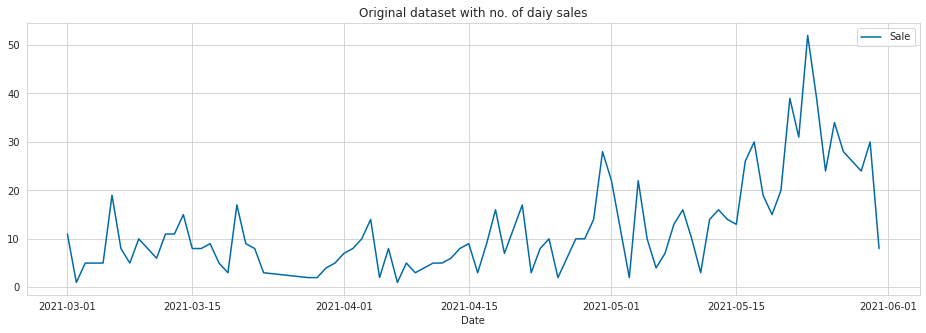

In [46]:
#plotting the data to describe the no.of daily sales
main_df.plot(figsize=(16,5))
plt.title('Original dataset with no. of daiy sales')


In [47]:
#Check the above graph to decide where to split train and test data

training_df = main_df.groupby(['Date'])['Sale'].sum().reset_index()
training_df['Date_temp'] = pd.to_datetime(training_df['Date']).dt.date
training_df.head()


,Date,Sale,Date_temp
0,2021-03-01,11,2021-03-01
1,2021-03-02,1,2021-03-02
2,2021-03-03,5,2021-03-03
3,2021-03-05,5,2021-03-05
4,2021-03-06,19,2021-03-06


Figure(1440x1440)


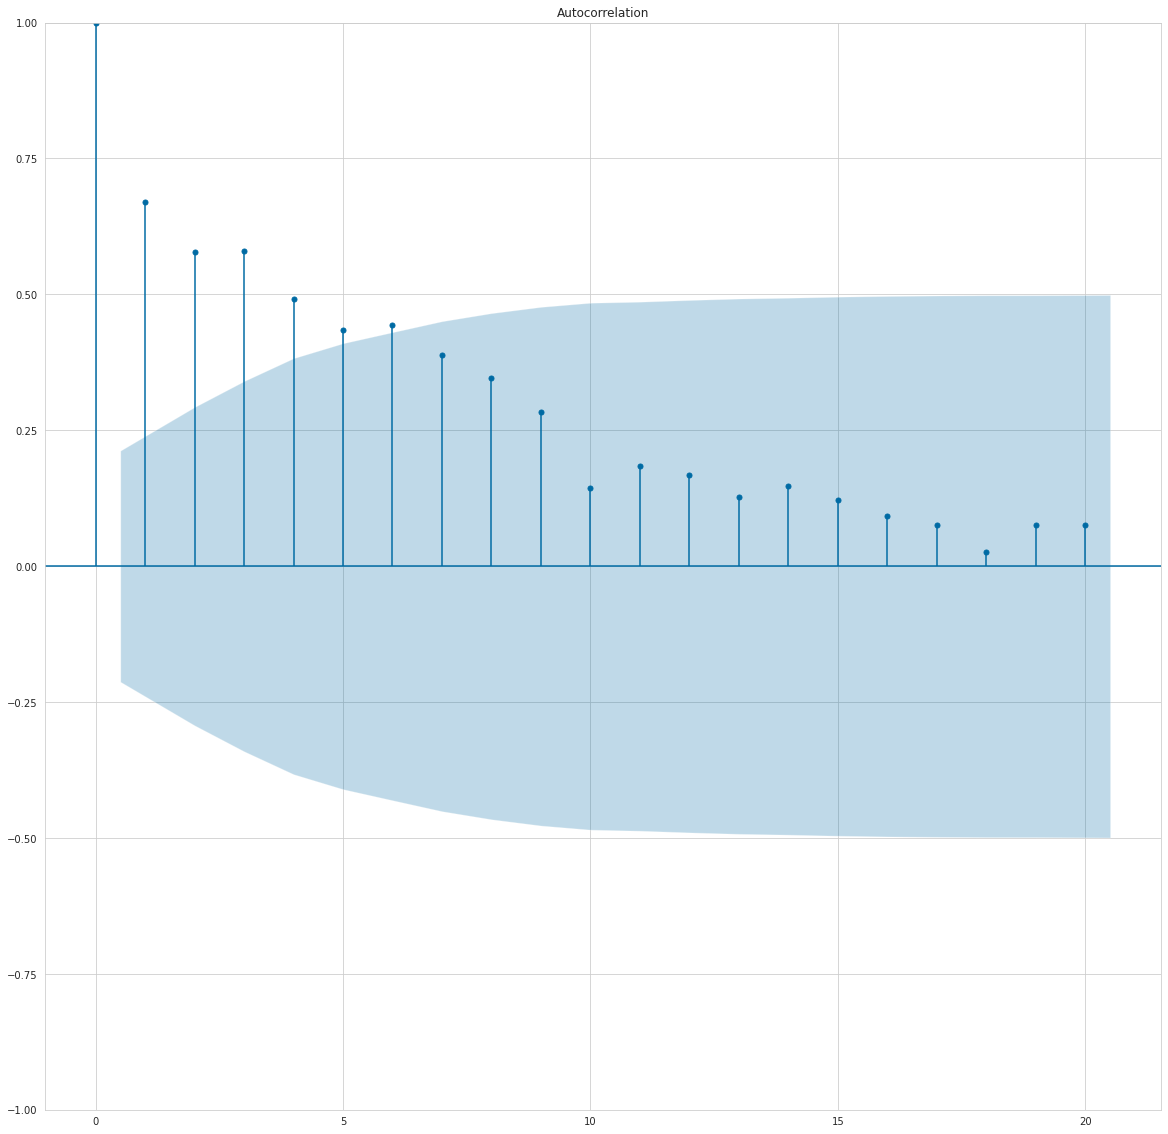

In [48]:
print(plot_acf(main_df, lags=20))

In [49]:
# training_df = training_df[training_df['Date'].isin(holidays) == False]
training_df['Date'] = pd.to_datetime(training_df['Date'])
training_df.head()

,Date,Sale,Date_temp
0,2021-03-01,11,2021-03-01
1,2021-03-02,1,2021-03-02
2,2021-03-03,5,2021-03-03
3,2021-03-05,5,2021-03-05
4,2021-03-06,19,2021-03-06


In [64]:
training_df.shape

(85, 2)

In [66]:
#splitting data on setting index
training_df.set_index('Date', inplace=True)


In [67]:
training_df.head()

,Sale,Date_temp
Date,,
2021-03-01,11,2021-03-01
2021-03-02,1,2021-03-02
2021-03-03,5,2021-03-03
2021-03-05,5,2021-03-05
2021-03-06,19,2021-03-06


In [60]:
training_df.head()

,Sale,Date_temp
Date,,
2021-04-01,7,2021-04-01
2021-04-02,8,2021-04-02
2021-04-03,10,2021-04-03
2021-04-04,14,2021-04-04
2021-04-05,2,2021-04-05


In [68]:
training_df.shape

(85, 2)

Text(0.5, 1.0, 'Training data for LANJZ2KTWN0HL0DPY448NCH3HJZV3P')

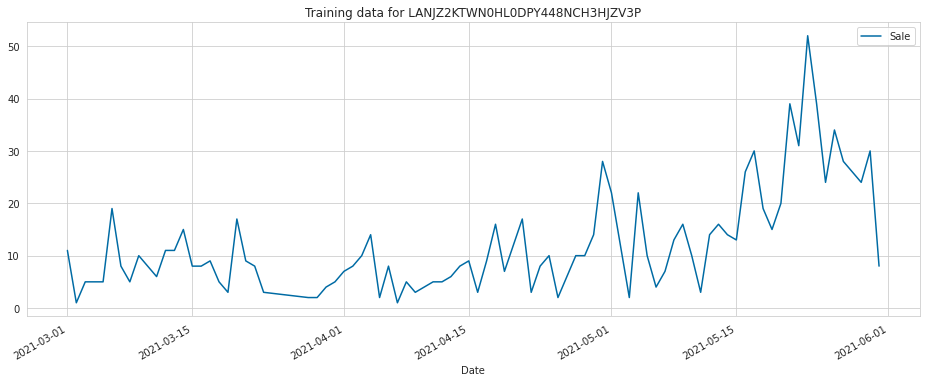

In [69]:
#training data from the date we choosen from 2012
training_df.plot(figsize=(16,6))
plt.title('Training data for LANJZ2KTWN0HL0DPY448NCH3HJZV3P')

In [70]:
training_df.head()

,Sale,Date_temp
Date,,
2021-03-01,11,2021-03-01
2021-03-02,1,2021-03-02
2021-03-03,5,2021-03-03
2021-03-05,5,2021-03-05
2021-03-06,19,2021-03-06


In [71]:
#describing the traning dataset
training_df.describe()

,Sale
count,85.000000
mean,12.388235
std,10.007252
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,52.000000


In [73]:
#Extracting more info settings for the xgboost
training_df['Year'] = pd.to_datetime(training_df['Date_temp']).dt.year
training_df['Week'] = pd.to_datetime(training_df['Date_temp']).dt.week
training_df['Day'] = pd.to_datetime(training_df['Date_temp']).dt.day
training_df['WeekDay'] = pd.to_datetime(training_df['Date_temp']).dt.dayofweek
#input sequence(t-n,...t-1)
for i in range(7,0,-1):
    training_df['lag' + str(i)] = training_df['Sale'].shift(i)

# training_df['Weekend'] = training_df.WeekDay.isin([5, 6]).astype(int)
"data Frame after adding more info as columns"
training_df.head()
training_df.dropna(inplace=True)

In [74]:
#finding corr between features added as columns
training_df.corr()

,Sale,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Sale,1.000000,NaN,0.595059,0.296394,0.197396,0.446213,0.500814,0.466368,0.518326,0.617564,0.610178,0.684150
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Week,0.595059,NaN,1.000000,0.252743,-0.052114,0.508574,0.536715,0.558605,0.571300,0.591487,0.630248,0.640667
Day,0.296394,NaN,0.252743,1.000000,-0.015289,0.403208,0.403086,0.411636,0.349259,0.307761,0.282032,0.277378
WeekDay,0.197396,NaN,-0.052114,-0.015289,1.000000,0.225940,0.158502,0.037418,0.039239,-0.114252,-0.135306,-0.068956
lag7,0.446213,NaN,0.508574,0.403208,0.225940,1.000000,0.647337,0.560446,0.590012,0.508732,0.488309,0.513994
lag6,0.500814,NaN,0.536715,0.403086,0.158502,0.647337,1.000000,0.661783,0.573863,0.601386,0.520054,0.503279
lag5,0.466368,NaN,0.558605,0.411636,0.037418,0.560446,0.661783,1.000000,0.673224,0.584082,0.625246,0.541324
lag4,0.518326,NaN,0.571300,0.349259,0.039239,0.590012,0.573863,0.673224,1.000000,0.680157,0.602701,0.637236
lag3,0.617564,NaN,0.591487,0.307761,-0.114252,0.508732,0.601386,0.584082,0.680157,1.000000,0.696831,0.612858


<AxesSubplot:xlabel='Sale'>

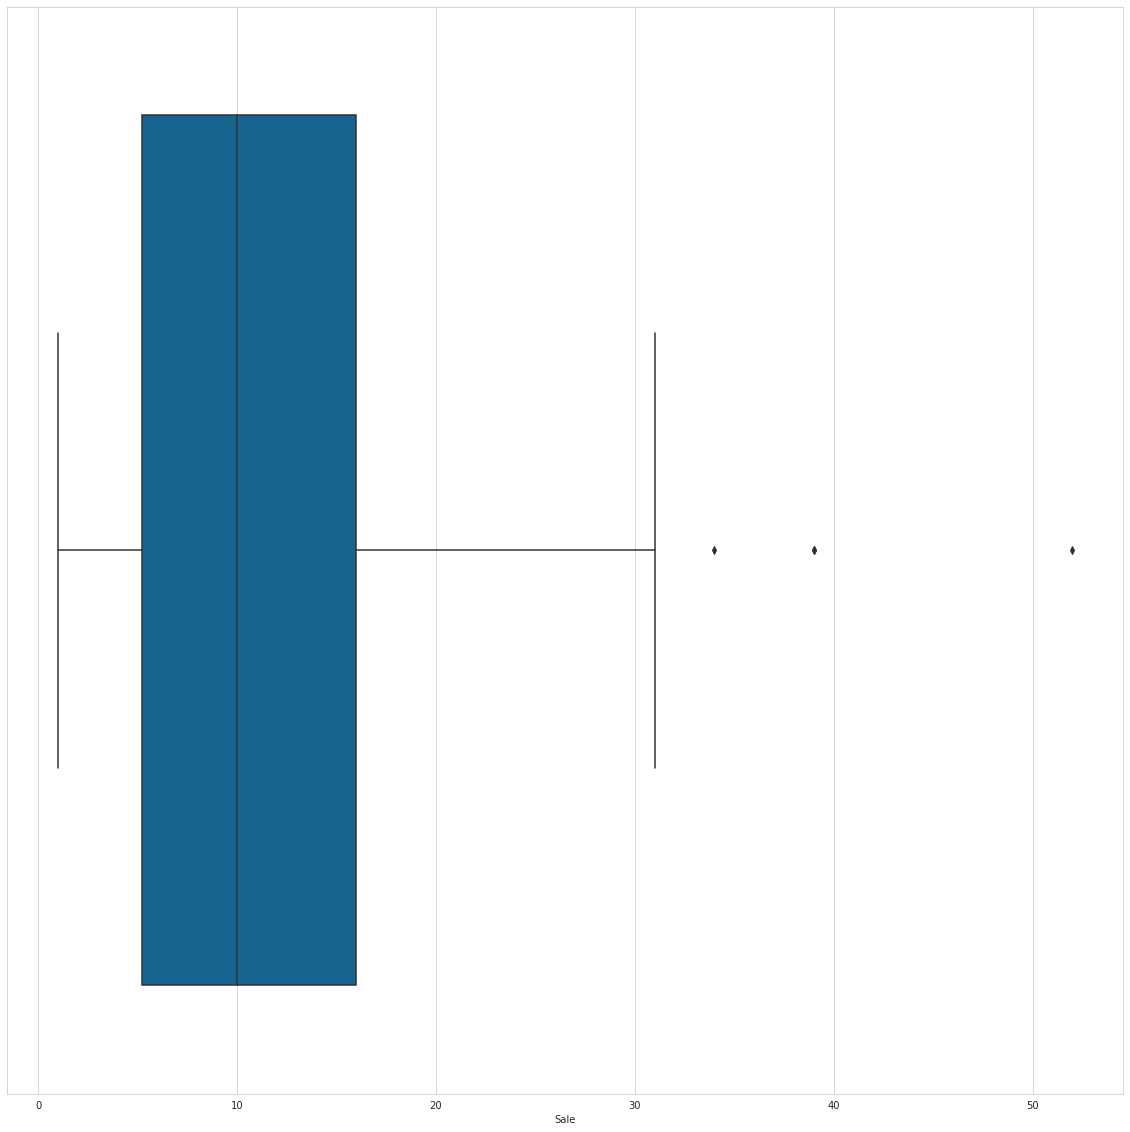

In [76]:
#ploting Sold Units boxplot
sns.boxplot(x=training_df['Sale'])

<AxesSubplot:xlabel='Week', ylabel='Sale'>

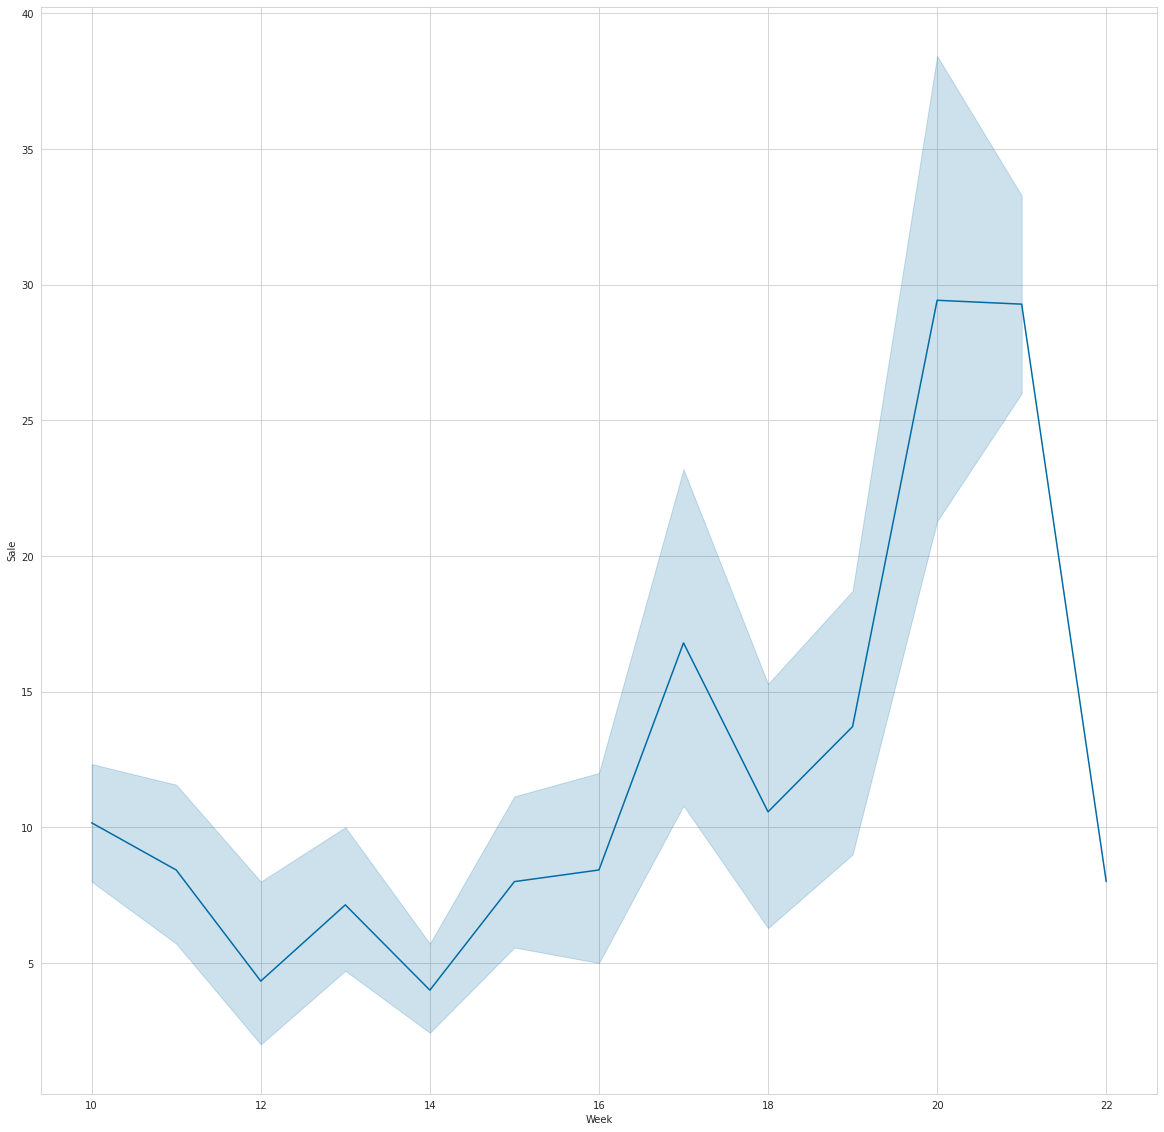

In [77]:
#ploting WEEK VS SOLD UNITS line plot
sns.lineplot(training_df['Week'], training_df['Sale'])

<AxesSubplot:xlabel='Week', ylabel='Sale'>

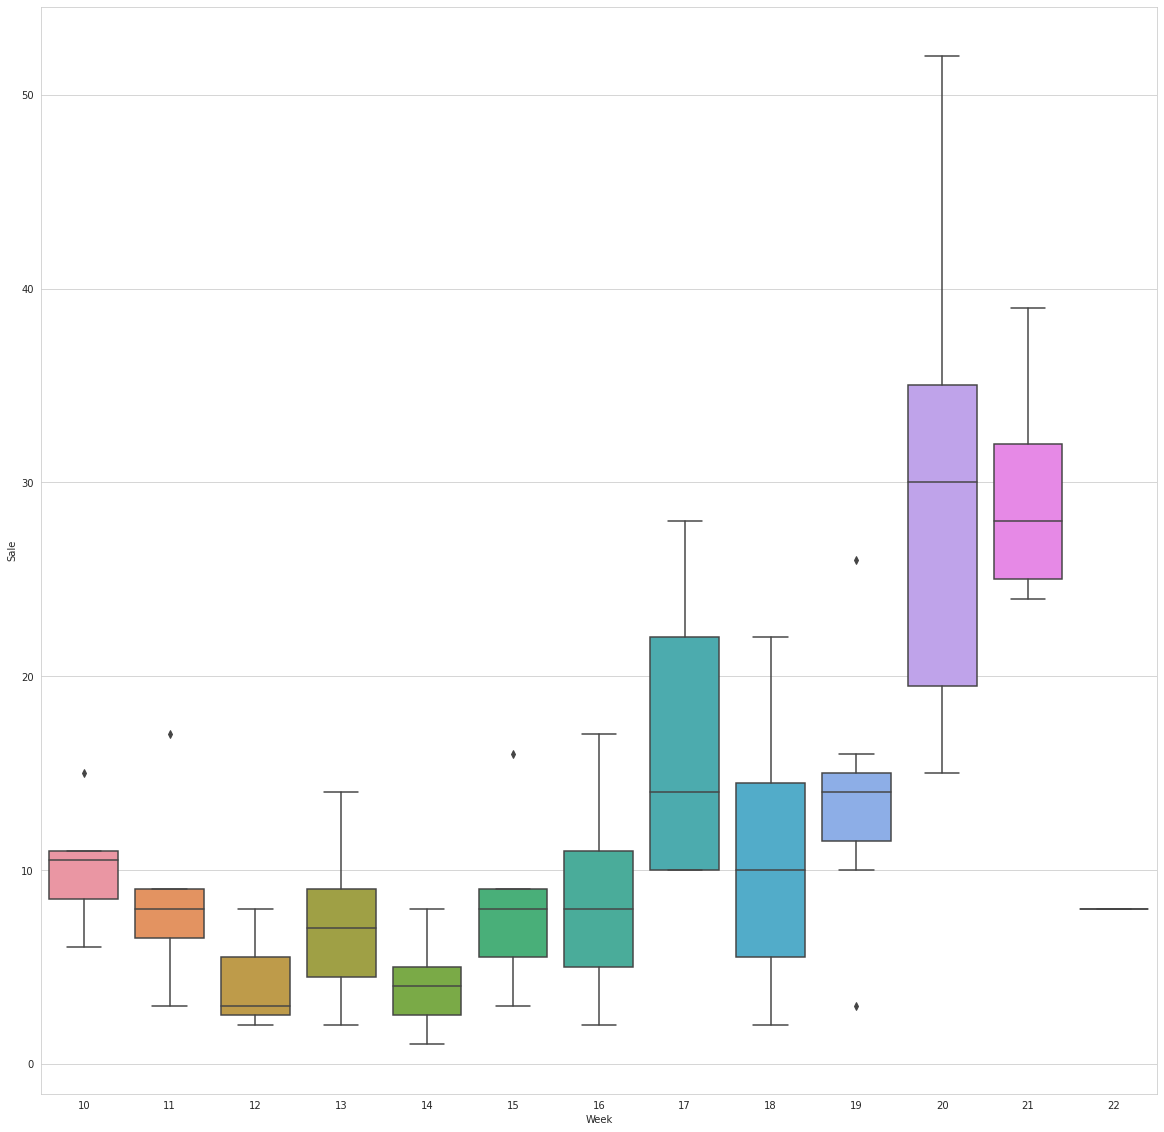

In [78]:
#ploting WEEK VS SOLD UNITS line plot
sns.boxplot(training_df['Week'], training_df['Sale'])

<AxesSubplot:xlabel='Day', ylabel='Sale'>

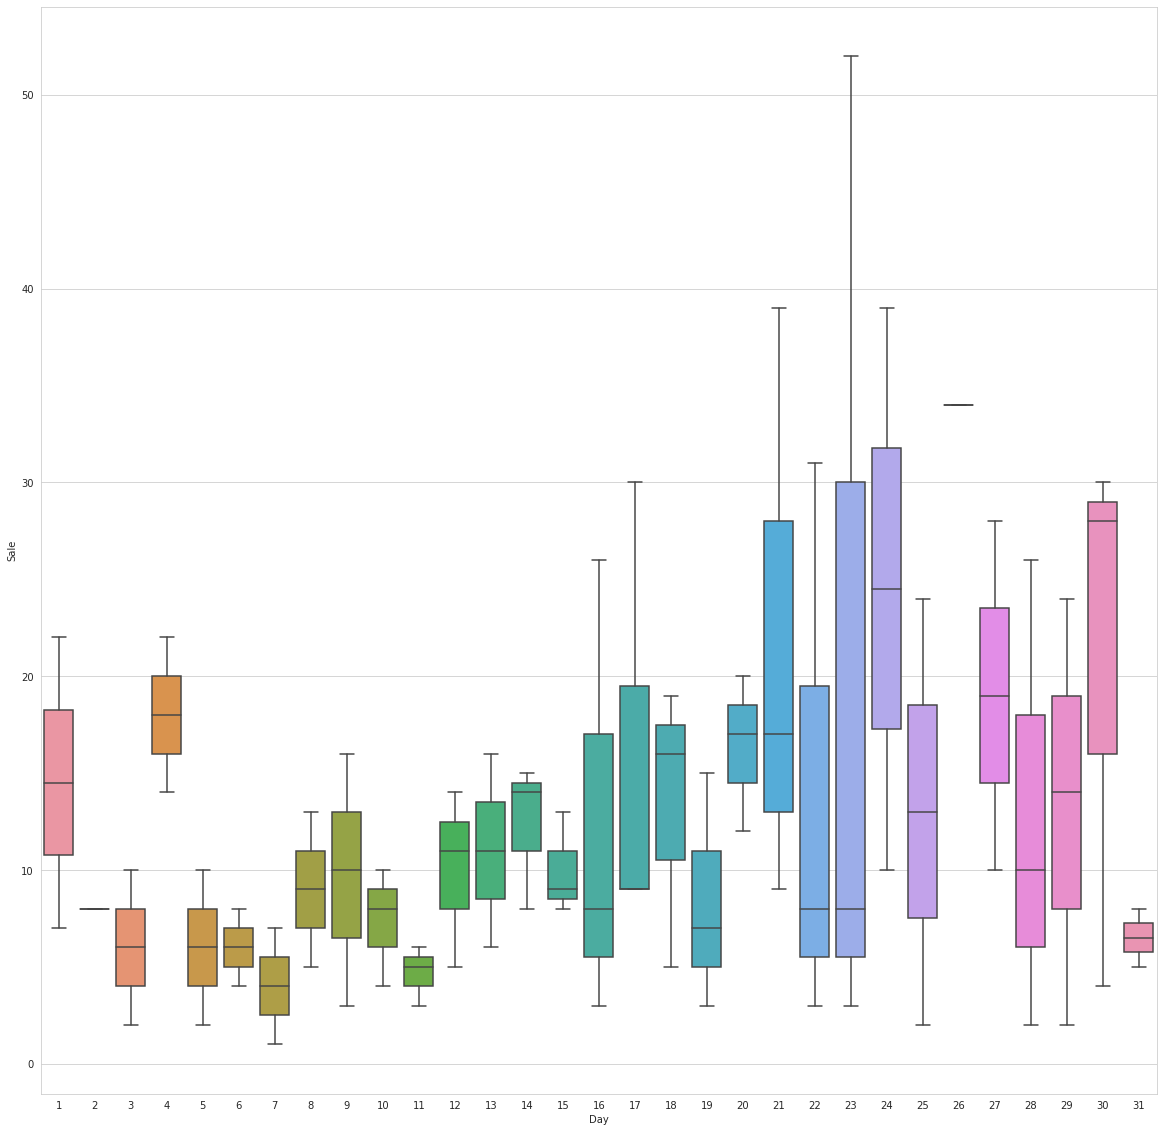

In [79]:
#ploting DAY VS SOLD UNITS line plot
sns.boxplot(training_df['Day'], training_df['Sale'])

In [80]:
training_df.describe()

,Sale,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
count,78.000000,78.0,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,12.807692,2021.0,15.794872,16.551282,2.974359,11.269231,11.435897,11.858974,12.153846,12.423077,12.487179,12.769231
std,10.218468,0.0,3.517522,8.397043,2.012780,9.410788,9.520436,9.780347,9.916636,10.004569,10.063104,10.242416
min,1.000000,2021.0,10.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.250000,2021.0,13.000000,10.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,10.000000,2021.0,16.000000,16.500000,3.000000,9.000000,9.000000,9.000000,9.000000,9.500000,9.500000,10.000000
75%,16.000000,2021.0,19.000000,23.000000,5.000000,14.000000,14.750000,15.000000,15.750000,16.000000,16.000000,16.000000
max,52.000000,2021.0,22.000000,31.000000,6.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000


In [ ]:
#selecting soldunits MIN and Max ranges in data frames
# training_df = training_df[training_df['AEP_MW']>290000]
# training_df.head()

In [ ]:
# training_df = training_df[training_df['AEP_MW'] < 490000]

In [ ]:
# training_df.drop(['Date'], axis=1, inplace=True)
# training_df.dtypes

In [ ]:
# training_df.size

In [ ]:
# training_df.head()


In [ ]:
# training_df.head()

In [122]:
#test train split on the dataset
#select the date at which want to split as satisfying train test split strategy
split_date = '2021-05-12'
df_train = training_df.loc[training_df.index <= split_date].copy()
df_test = training_df.loc[training_df.index > split_date].copy()

In [123]:
df_train.head()

,Sale,Date_temp,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Date,,,,,,,,,,,,,
2021-03-09,10,2021-03-09,2021,10,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-10,8,2021-03-10,2021,10,10,2,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2021-03-11,6,2021-03-11,2021,10,11,3,NaN,NaN,NaN,NaN,NaN,10.0,8.0
2021-03-12,11,2021-03-12,2021,10,12,4,NaN,NaN,NaN,NaN,10.0,8.0,6.0
2021-03-13,11,2021-03-13,2021,10,13,5,NaN,NaN,NaN,10.0,8.0,6.0,11.0


In [124]:
df_test.head()

,Sale,Date_temp,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Date,,,,,,,,,,,,,
2021-05-13,16,2021-05-13,2021,19,13,3,4.0,7.0,13.0,16.0,10.0,3.0,14.0
2021-05-14,14,2021-05-14,2021,19,14,4,7.0,13.0,16.0,10.0,3.0,14.0,16.0
2021-05-15,13,2021-05-15,2021,19,15,5,13.0,16.0,10.0,3.0,14.0,16.0,14.0
2021-05-16,26,2021-05-16,2021,19,16,6,16.0,10.0,3.0,14.0,16.0,14.0,13.0
2021-05-17,30,2021-05-17,2021,20,17,0,10.0,3.0,14.0,16.0,14.0,13.0,26.0


In [125]:
df_train.shape

(59, 13)

In [126]:
df_test.shape

(19, 13)

In [127]:
#creating features for timeseries to the dataset
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in range(7,0,-1):
        training_df['lag' + str(i)] = training_df['Sale'].shift(i)
    X = df[[
        'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear','lag7','lag6','lag5','lag4','lag3','lag2','lag1',
    ]]
    if label:
        y = df[label]
        return X, y
    return X

In [128]:
#splitting the data into train and test
X_train, y_train = create_features(df_train, label='Sale')
X_test, y_test = create_features(df_test, label='Sale')

In [129]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Date,,,,,,,,,,,,,,
2021-03-09,1,1,3,2021,68,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-10,2,1,3,2021,69,10,10,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2021-03-11,3,1,3,2021,70,11,10,NaN,NaN,NaN,NaN,NaN,10.0,8.0
2021-03-12,4,1,3,2021,71,12,10,NaN,NaN,NaN,NaN,10.0,8.0,6.0
2021-03-13,5,1,3,2021,72,13,10,NaN,NaN,NaN,10.0,8.0,6.0,11.0


In [130]:
y_train.head()

Date
2021-03-09    10
2021-03-10     8
2021-03-11     6
2021-03-12    11
2021-03-13    11
Name: Sale, dtype: int64

In [131]:
#creating XGBoost Model
#Tunning the Hyper Parameters with  GridSearchCV

# here is a Parameter grid for the xgboost
params = {
    'min_child_weight': [4, 5],
    'eta' : [i / 10.0 for i in range(3, 6)],
    'lambda' : [0.2],
    'alpha' : [0.3],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

In [132]:
# Intializing XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

In [133]:
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
   

In [ ]:
# reg = xgb.XGBRegressor(n_estimators=1000)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
#        verbose=False)

In [134]:
gridcv_xgb = grid.best_estimator_
r2_score(y_test, gridcv_xgb.predict(X_test))

-2.323640537543534

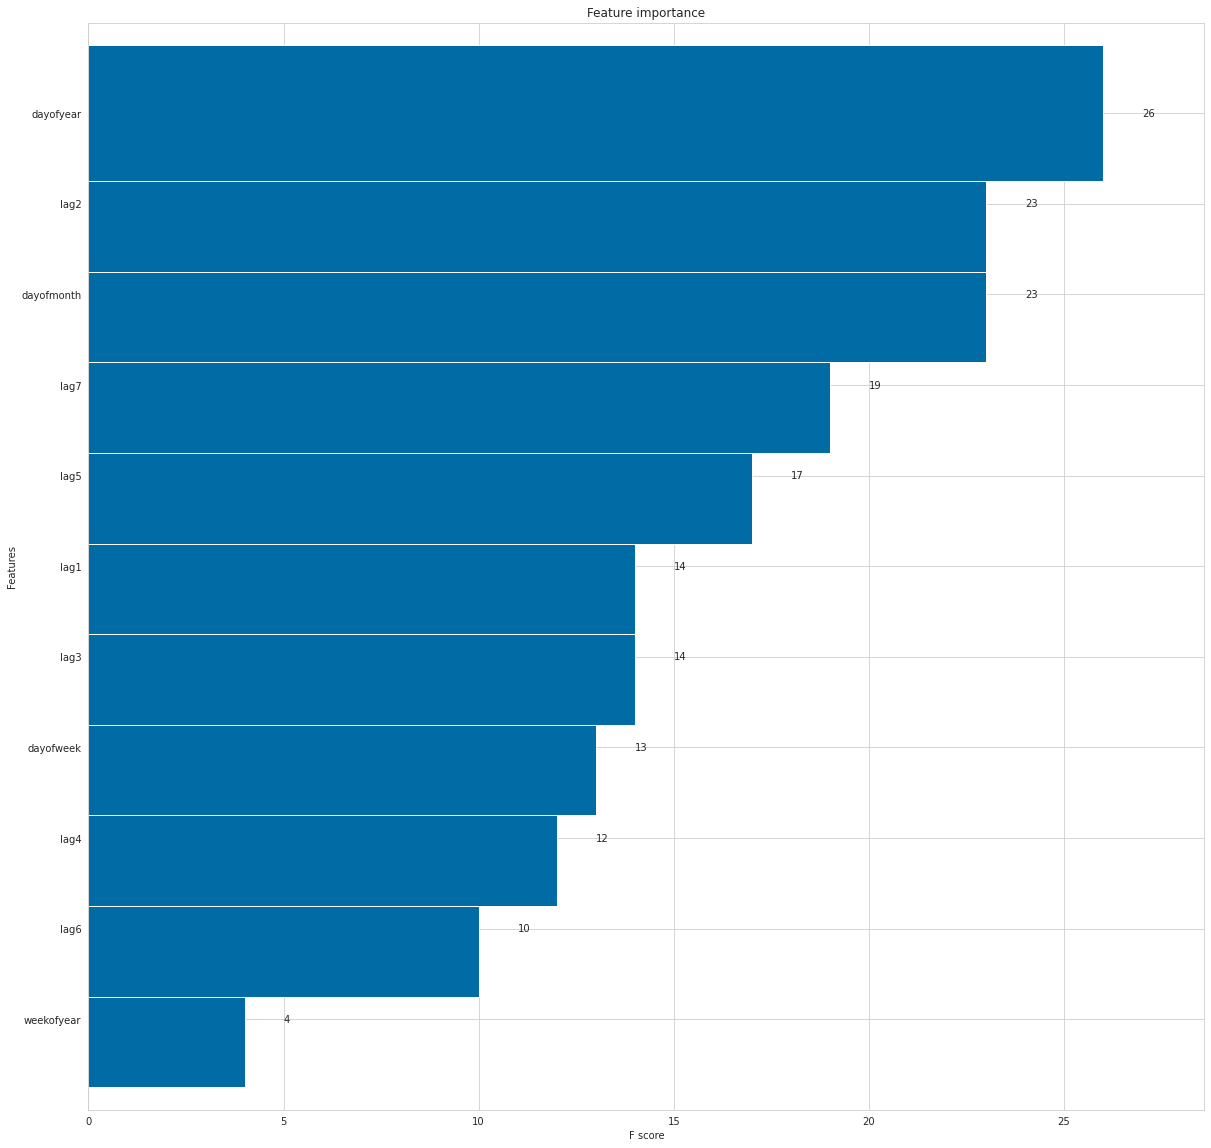

In [135]:
#feature importance graph
_ = plot_importance(gridcv_xgb, height=1.5)
plt.show()

In [136]:
#forecasting the data
df_test['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

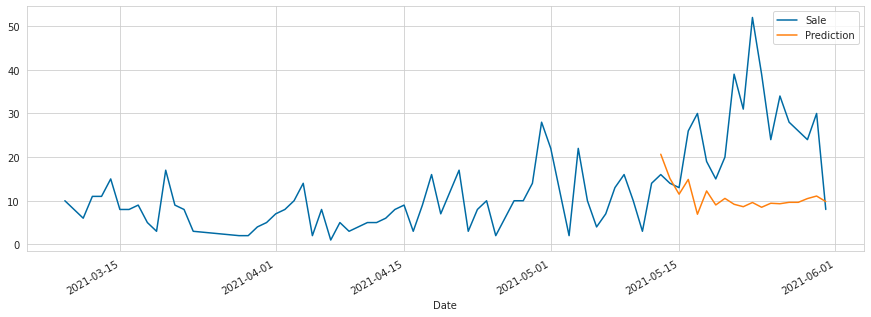

In [137]:
_ = df_all[['Sale','Prediction']].plot(figsize=(15, 5))

In [138]:
#first month predictions
df_all.head().T

Date,2021-05-13,2021-05-14,2021-05-15,2021-05-16,2021-05-17
Sale,16,14,13,26,30
Date_temp,2021-05-13,2021-05-14,2021-05-15,2021-05-16,2021-05-17
Year,2021,2021,2021,2021,2021
Week,19,19,19,19,20
Day,13,14,15,16,17
WeekDay,3,4,5,6,0
lag7,4.0,7.0,13.0,16.0,10.0
lag6,7.0,13.0,16.0,10.0,3.0
lag5,13.0,16.0,10.0,3.0,14.0
lag4,16.0,10.0,3.0,14.0,16.0


In [ ]:
print("root mean squared error")
mean_squared_error(y_true=df_test['Sale'],
                   y_pred=df_test['Prediction'])

In [ ]:
print("root absolute error")
mean_absolute_error(y_true=df_test['Sale'],
                   y_pred=df_test['Prediction'])

In [ ]:
#mean absolute percentage eror
def mean_absolute_percentage_error(y_true, y_pred):
    # """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print("mean absolute percentage error")
mean_absolute_percentage_error(y_true=df_test['Sale'],
                   y_pred=df_test['Prediction'])

In [139]:
#Looking at wrost and best predicted days
df_test['error'] = df_test['Sale'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Sale', 'Prediction', 'error', 'abs_error']]

In [140]:
print("The Wrost predicted days")
# Over forecasted days
print(error_by_day.sort_values('error', ascending=True).head())

The Wrost predicted days
                       Sale  Prediction     error  abs_error
year month dayofmonth                                       
2021 5     13          16.0   20.656738 -4.656738   4.656738
           31           8.0    9.809217 -1.809217   1.809217
           14          14.0   15.085603 -1.085603   1.085603
           15          13.0   11.497906  1.502094   1.502094
           19          15.0    9.037656  5.962344   5.962344


In [141]:
# Best predicted days
print("The Best predicted days")
print(error_by_day.sort_values('abs_error', ascending=True).head())

The Best predicted days
                       Sale  Prediction     error  abs_error
year month dayofmonth                                       
2021 5     14          14.0   15.085603 -1.085603   1.085603
           15          13.0   11.497906  1.502094   1.502094
           31           8.0    9.809217 -1.809217   1.809217
           13          16.0   20.656738 -4.656738   4.656738
           19          15.0    9.037656  5.962344   5.962344


<Figure size 1440x1440 with 0 Axes>